In [1]:
import lib.PrintImg
import lib.DataInput
import gc
from sklearn.cross_validation import train_test_split
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

from lib.func import convert_to_grayscale as convert_to_grayscale
import numpy as np
from matplotlib import pyplot as plt


C:\Users\luzengxiang\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15410090111338965890
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6760141291
locality {
  bus_id: 1
}
incarnation: 10306844101959498752
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
file1 = "0043db5e8c819bffc15261b1f1ac5e42.aps"
file2 = "00360f79fd6e02781457eda48f85da90.aps"
lib.PrintImg.save_images("../sample_data/"+file2,"../sample_image/"+file2)

In [3]:
data = convert_to_grayscale(lib.DataInput.read_data("../sample_data/"+file2))

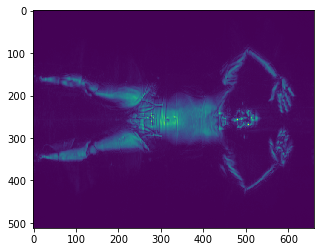

In [14]:
plt.imshow(data[:,:,0])
plt.show()

In [11]:
data.shape

(512, 660, 16)

In [3]:
import pandas as pd
data_label = pd.read_csv("../data/stage1_labels.csv")
data_label.columns

Index(['Id', 'Probability'], dtype='object')

In [4]:
import re
data_label["graph_ID"]= data_label["Id"].map(lambda x: re.split("_",x)[0])
data_label["Zone"]= data_label["Id"].map(lambda x: re.split("_",x)[1][4:])

In [5]:
label = data_label.pivot(index='graph_ID', columns='Zone', values='Probability')

In [6]:
import numpy as np
label = label[[str(i) for i in range(1,18)]]
label_dict = dict()
for index, row in label.iterrows():
    label_dict[index] = row.tolist()

In [ ]:
from os import walk,path
import sys
name_list=[]
response = []
file_list = []
for (dirpath, dirnames, filenames) in walk("../data/"):  
    sys.stderr.write("Directory path : "+dirpath+'\n')
    sys.stderr.write("Total number of files : "+ str(len(filenames))+'\n')
    file_index =  0
    for name in filenames:
        file_index +=1
        if (file_index % 100) == 1:
            sys.stderr.write("Current file : "+'['+str(file_index)+'/'+str(len(filenames))+']'+'\n')
        if name[0] =='.':
            continue
        if re.split('\.',str(name))[-1] == 'aps':
            G_id = re.split('\.',str(name))[0]
            if label_dict.get(G_id) != None:
                name_list.append(G_id)
                file_list.append(path.join(dirpath, name))
                response.append(label_dict.get(G_id))

#memory_limitation
file_list = file_list[0:800]
response = response[0:800]

train_file,test_file,Y_train,Y_test = train_test_split(file_list,response,test_size =0.2,random_state=4)
angle= [0,3,6,9,12,15]
index = 0 
sys.stderr.write("Road training data:"+'\n')
for file in train_file:
    if (index % 100) == 0:
        sys.stderr.write("Current file : "+'['+str(index+1)+'/'+str(len(train_file))+']'+'\n')
    graph = convert_to_grayscale(lib.DataInput.read_data(file)[:,:,angle])
    if index  == 0:
        X_train = np.zeros([len(train_file)]+list(graph.shape))
    X_train[index,:,:,:] = graph
    index += 1
sys.stderr.write("Training data done, shape : "+ str(X_train.shape)+'\n')
                         
index = 0 
sys.stderr.write("Road test data:"+'\n')
for file in test_file:
    if (index % 100) == 0:
        sys.stderr.write("Current file : "+'['+str(index+1)+'/'+str(len(test_file))+']'+'\n')
    graph = lib.DataInput.read_data(file)[:,:,angle]
    if index  == 0:
        X_test = np.zeros([len(test_file)]+list(graph.shape))
    X_test[index,:,:,:] = graph
    index += 1
sys.stderr.write("test data done, shape : "+ str(X_test.shape)+'\n')

Directory path : ../data/
Total number of files : 1
Current file : [1/1]
Directory path : ../data/aps
Total number of files : 1216
Current file : [1/1216]
Current file : [101/1216]
Current file : [201/1216]
Current file : [301/1216]
Current file : [401/1216]
Current file : [501/1216]
Current file : [601/1216]
Current file : [701/1216]
Current file : [801/1216]
Current file : [901/1216]
Current file : [1001/1216]
Current file : [1101/1216]
Current file : [1201/1216]
Road training data:
Current file : [1/640]
Current file : [101/640]
Current file : [201/640]
Current file : [301/640]
Current file : [401/640]
Current file : [501/640]
Current file : [601/640]
Training data done, shape : (640, 512, 660, 6)
Road test data:
Current file : [1/160]


In [83]:
gc.collect()

0

In [85]:
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten


In [86]:
#hyper parameters
num_classes = len(Y_train[0])
num_train= len(X_train)
height, width, depth = X_train[0,:,:,:].shape 
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 200 # we iterate 200 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons

In [87]:
inp = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2)
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2)
hidden = Dense(hidden_size, activation='relu')(flat)
drop_3 = Dropout(drop_prob_2)(hidden)
out = Dense(num_classes, activation='softmax')(drop_3)


In [19]:
model = Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

model.fit(X_train, Y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
Y_test_pred = model.predict(X_test,verbose=1)  # Evaluate the trained model on the test set!

NameError: name 'Model' is not defined

In [17]:
from os import walk,path
import sys
import re
name_list = []
response = []
file_list = []
for (dirpath, dirnames, filenames) in walk("../data/"):
    sys.stderr.write("Directory path : " + dirpath + '\n')
    sys.stderr.write("Total number of files : " + str(len(filenames)) + '\n')
    file_index = 0
    for name in filenames:
        file_index += 1
        if (file_index % 100) == 1:
            sys.stderr.write("Current file : " + '[' + str(file_index) + '/' + str(len(filenames)) + ']' + '\n')
        if name[0] == '.':
            continue
        if re.split('\.', str(name))[-1] == 'aps':
            G_id = re.split('\.', str(name))[0]
            if label_dict.get(G_id) != None:
                name_list.append(G_id)
                file_list.append(path.join(dirpath, name))
                response.append(label_dict.get(G_id)[4])

# memory_limitation
file_list = file_list[0:800]
response = response[0:800]


train_file, test_file, Y_train, Y_test = train_test_split(file_list, response, test_size=0.2, random_state=4)

Directory path : ../data/
Total number of files : 1
Current file : [1/1]
Directory path : ../data/aps
Total number of files : 1216
Current file : [1/1216]
Current file : [101/1216]
Current file : [201/1216]
Current file : [301/1216]
Current file : [401/1216]
Current file : [501/1216]
Current file : [601/1216]
Current file : [701/1216]
Current file : [801/1216]
Current file : [901/1216]
Current file : [1001/1216]
Current file : [1101/1216]
Current file : [1201/1216]


In [18]:
Y_train = np.array(Y_train)

In [22]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [12]:
from lib.crop_image import import_eps

C:\Users\luzengxiang\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
X_train,X_test,Y_train,Y_test = import_eps("../data",'../data/stage1_labels.csv',7)

Directory path : ../data
Total number of files : 2
Current file : [1/2]
Directory path : ../data\aps
Total number of files : 1216
Current file : [1/1216]
Current file : [101/1216]
Current file : [201/1216]
Current file : [301/1216]
Current file : [401/1216]
Current file : [501/1216]
Current file : [601/1216]
Current file : [701/1216]
Current file : [801/1216]
Current file : [901/1216]
Current file : [1001/1216]
Current file : [1101/1216]
Current file : [1201/1216]
Directory path : ../data\processed
Total number of files : 4
Current file : [1/4]
Road training data:
Current file : [1/892]
Current file : [101/892]
Current file : [201/892]
Current file : [301/892]
Current file : [401/892]
Current file : [501/892]
Current file : [601/892]
Current file : [701/892]
Current file : [801/892]
Training data done, shape : (892, 250, 250, 8)
Current file : [1/223]
Current file : [101/223]
Current file : [201/223]
Training data done, shape : (892, 250, 250, 8)


In [19]:
import numpy as np
np.save("../data/processed/X_test",X_test)
np.save("../data/processed/X_train",X_train)
np.save("../data/processed/Y_test",Y_test)
np.save("../data/processed/Y_train",Y_train)

In [1]:
import numpy as np
X_test = np.load("../data/processed/X_test.npy")
X_train = np.load("../data/processed/X_train.npy")
Y_test = np.load("../data/processed/Y_test.npy")
Y_train = np.load("../data/processed/Y_train.npy")

In [2]:
from lib.AlexNet import model_generator
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
model = model_generator(X_train[0,:,:,:].shape)

C:\Users\luzengxiang\Desktop\CISC879 Project\CISC879_Project\src\lib\AlexNet.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
C:\Users\luzengxiang\Desktop\CISC879 Project\CISC879_Project\src\lib\AlexNet.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
C:\Users\luzengxiang\Desktop\CISC879 Project\CISC879_Project\src\lib\AlexNet.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
  model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
C:\Users\luzengxiang\Desktop\CISC879 Project\CISC879_Project\src\lib\AlexNet.py:54: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", na

In [4]:
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

In [5]:
import numpy as np
banch_mark = np.mean(Y_train[:,0])
banch_mark

0.9170403587443946

In [ ]:
import keras.backend as K
from keras import optimizers
from keras.optimizers import SGD


# For custom metrics

def mean_pred(y_true, y_pred):
    return K.mean(y_pred[:,0])

opt = SGD(lr=0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt,metrics=['accuracy', mean_pred])

model.fit(X_train, Y_train,                # Train the model using the training set...
          batch_size=16, epochs=10,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation

Train on 802 samples, validate on 90 samples
Epoch 1/10
802/802 [==============================] - 34s 42ms/step - loss: 0.3568 - acc: 0.9127 - mean_pred: 0.8747 - val_loss: 0.3941 - val_acc: 0.9000 - val_mean_pred: 0.9798
Epoch 2/10
802/802 [==============================] - 28s 35ms/step - loss: 0.3038 - acc: 0.9190 - mean_pred: 0.9018 - val_loss: 0.3494 - val_acc: 0.9000 - val_mean_pred: 0.9624
Epoch 3/10
802/802 [==============================] - 29s 36ms/step - loss: 0.2999 - acc: 0.9190 - mean_pred: 0.9060 - val_loss: 0.3424 - val_acc: 0.9000 - val_mean_pred: 0.9605
Epoch 4/10
802/802 [==============================] - 29s 36ms/step - loss: 0.2950 - acc: 0.9190 - mean_pred: 0.9045 - val_loss: 0.3767 - val_acc: 0.9000 - val_mean_pred: 0.9763
Epoch 5/10
802/802 [==============================] - 29s 36ms/step - loss: 0.2878 - acc: 0.9190 - mean_pred: 0.9108 - val_loss: 0.3423 - val_acc: 0.9000 - val_mean_pred: 0.9637
Epoch 6/10
240/802 [=======>......................] - ETA: 19s - 

array([ 1.,  0.])

In [1]:
from lib.crop_image import import_eps
X,Y = import_eps("../data",'../data/stage1_labels.csv',7)

C:\Users\luzengxiang\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
Directory path : ../data
Total number of files : 2
Current file : [1/2]
Directory path : ../data\aps
Total number of files : 1216
Current file : [1/1216]
Current file : [101/1216]
Current file : [201/1216]
Current file : [301/1216]
Current file : [401/1216]
Current file : [501/1216]
Current file : [601/1216]
Current file : [701/1216]
Current file : [801/1216]
Current file : [901/1216]
Current file : [1001/1216]
Current file : [1101/1216]
Current file : [1201/1216]
Directory path : ../data\processed
Total number of files : 4
Curren

In [2]:
from lib.AlexNet import model_generator
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras.optimizers import SGD

opt = SGD(lr=0.01)

# For custom metrics

def mean_pred(y_true, y_pred):
    return K.mean(y_pred[:,0])
model = model_generator(X[0,:,:,:].shape)
model.compile(loss = "categorical_crossentropy", optimizer = opt,metrics=['accuracy', mean_pred])

model.fit(X, Y,                # Train the model using the training set...
          batch_size=32, epochs=100,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation

SyntaxError: invalid syntax (AlexNet.py, line 118)

In [9]:
tY

NameError: name 'tY' is not defined

In [10]:
Y

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [16]:
a=Y[:,1]

In [17]:
[i for i,j in enumerate(a) if j==1]

[10,
 11,
 14,
 18,
 24,
 34,
 39,
 72,
 87,
 107,
 114,
 128,
 137,
 144,
 168,
 170,
 178,
 226,
 244,
 245,
 246,
 248,
 251,
 266,
 274,
 295,
 296,
 297,
 298,
 327,
 329,
 337,
 340,
 352,
 383,
 385,
 409,
 412,
 417,
 419,
 456,
 459,
 466,
 482,
 493,
 499,
 505,
 516,
 526,
 552,
 613,
 629,
 640,
 651,
 666,
 693,
 702,
 705,
 713,
 739,
 752,
 757,
 770,
 772,
 786,
 794,
 797,
 801,
 832,
 844,
 846,
 848,
 853,
 854,
 855,
 860,
 872,
 879,
 892,
 904,
 907,
 908,
 919,
 991,
 1027,
 1045,
 1053,
 1054,
 1059,
 1080,
 1089,
 1110]

In [18]:
Y[10]

array([ 0.,  1.])

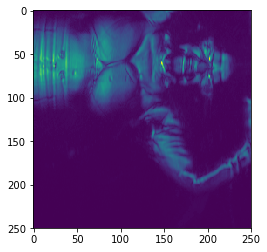

In [38]:
from matplotlib import pyplot as plt

plt.imshow(X[11,:,:,0])
plt.show()